#### Objective: To analyze geotagged Flickr photos and find popular photography spots in NYC. 

##### Step 1: Import necessary packages

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# pip install scikit-learn

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [4]:
from sklearn.cluster import DBSCAN

##### Step 2: Load the data

In [5]:
nyc_neighborhoods_path = 'data/5_geotaggedPhoto/Neighborhood.shp' 
flickr_data_path = 'data/5_geotaggedPhoto/Flickr_NewYork.csv' 

# Load the NYC Neighborhood shapefile
nyc_neighborhoods = gpd.read_file(nyc_neighborhoods_path)
# Load the Flickr data
flickr_data = pd.read_csv(flickr_data_path)

##### Step 3: Explore the data

In [6]:
# Print column names to check for latitude and longitude
print(len(flickr_data.columns))
print(flickr_data.columns)

6
Index(['14646779624', '30370599@N02', '40.67718', '-73.983092',
       'city nyc newyorkcity urban usa ny newyork brooklyn america graffiti unitedstates vandalism gowanus tagging 212',
       'https://farm6.staticflickr.com/5501/14646779624_228a711fc9_z.jpg'],
      dtype='object')


In [7]:
# Specifying column names
column_names = ['id', 'user', 'latitude', 'longitude', 'tags','image'] 
flickr_data = pd.read_csv(flickr_data_path, header=None, names=column_names)

##### Step 4: Plot NYC boundary and Flickr photo points.

In [8]:
# Now let's convert the latitude and longitude to a GeoDataFrame
gdf_flickr = gpd.GeoDataFrame(
    flickr_data, 
    geometry=gpd.points_from_xy(flickr_data.longitude, flickr_data.latitude),
    crs="EPSG:4326"
)

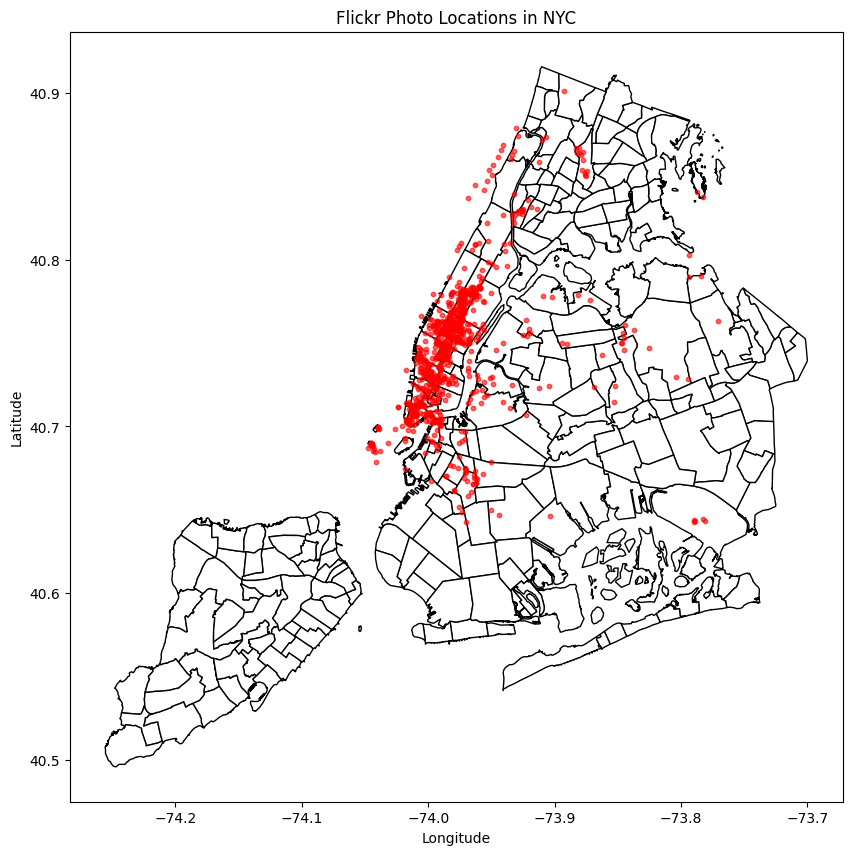

In [9]:
# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
nyc_neighborhoods.plot(ax=ax, color='white', edgecolor='black')
gdf_flickr.plot(ax=ax, markersize=10, color='red', alpha=0.6)
plt.title('Flickr Photo Locations in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

##### Step 5: Using silhouette to determine the k for K-means clustering.

In [10]:
# Prepare the data for clustering (using only the latitude and longitude)
coordinates = flickr_data[['latitude', 'longitude']].values

# Test k from 5 to 20 and calculate silhouette scores
silhouette_scores = []
K_range = range(5, 21)

In [11]:
for K in K_range:
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(coordinates)
    silhouette_avg = silhouette_score(coordinates, cluster_labels)
    silhouette_scores.append(silhouette_avg)

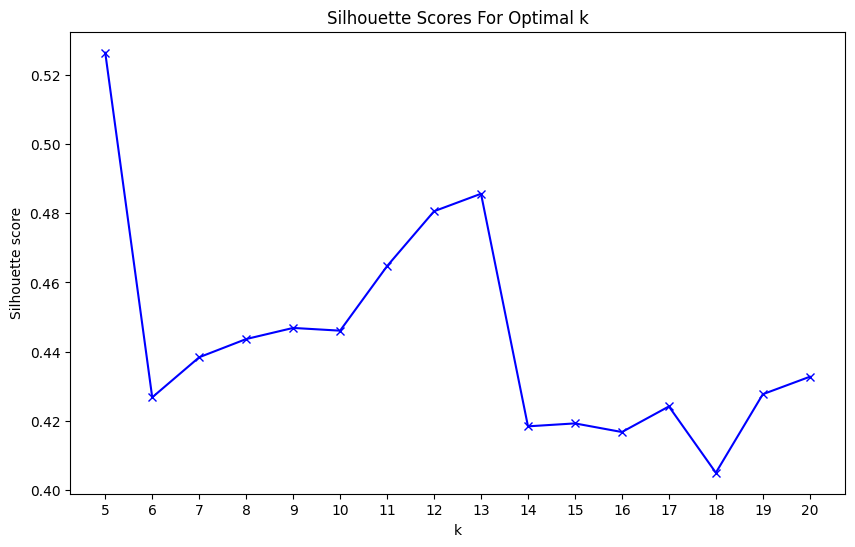

In [12]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Scores For Optimal k')
plt.xticks(K_range)
plt.show()

###### Note: The plot suggests that k=5 and 13 are a good values to consider, so let’s create model and use it to cluster the photo locations, and visualize the result.

In [13]:
# Initialize KMeans with k=13
kmeans = KMeans(n_clusters=13, n_init=10, random_state=42)

# Fit the model to the coordinates
kmeans.fit(coordinates)

# Predict the cluster indices for the coordinates
cluster_labels = kmeans.predict(coordinates)

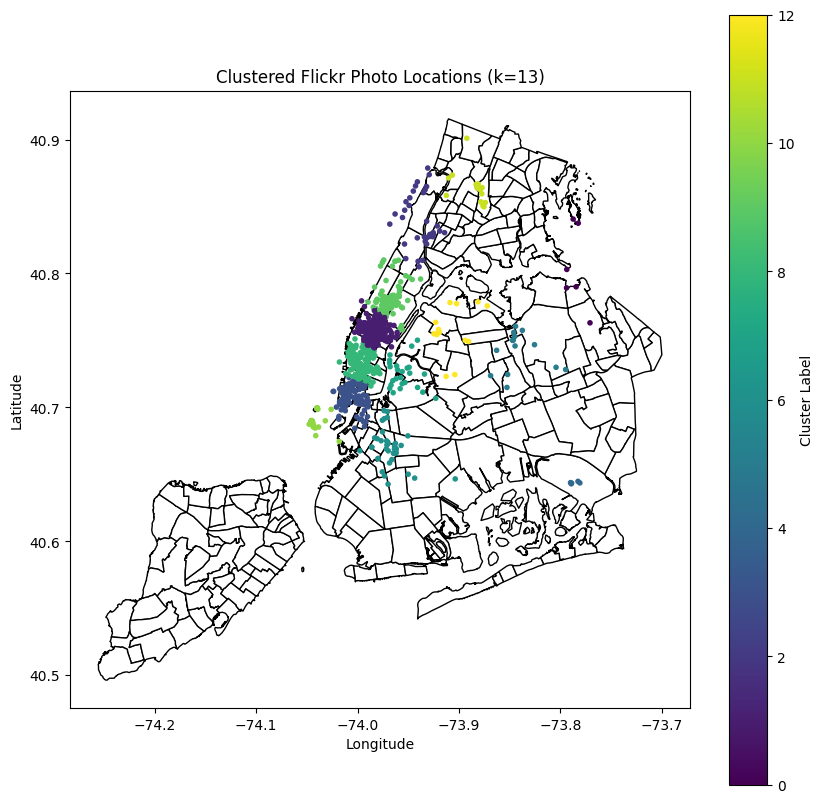

In [14]:
# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 10))
nyc_neighborhoods.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(coordinates[:, 1], coordinates[:, 0], c=cluster_labels, cmap='viridis', marker='.')
plt.title('Clustered Flickr Photo Locations (k=13)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

In [15]:
color_array = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
               '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
               '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
               '#aaffc3', '#808000', '#ffd8b1', '#000075']

# Creating a color for each cluster label based on the color array
cluster_colors = [color_array[label] for label in cluster_labels]

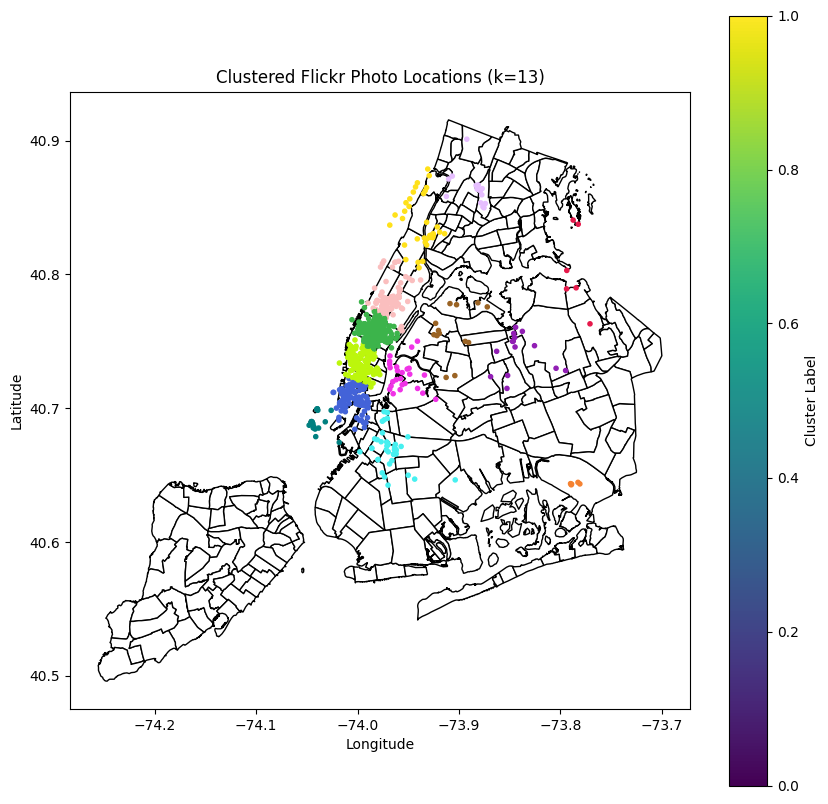

In [16]:
# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
nyc_neighborhoods.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(coordinates[:, 1], coordinates[:, 0], c=cluster_colors, marker='.')
plt.title('Clustered Flickr Photo Locations (k=13)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

##### Step 6: DBSCAN clustering. Using 0.002 for Eps and 5 for MinPts, and creating a DBSCAN model to cluster the location points.

###### Assuming a domain expert tells that areas of interest can be defined generally based on the fact that at least 5 people have taken photos within a radius of 200 meteres (about 0.002 degrees). We can then make use of this information by using DBSCAN and setting its parameters to 0.002 for Eps and 5 for MinPts.

In [17]:
# Parameters for DBSCAN
eps = 0.002  # Epsilon value for DBSCAN
min_samples = 5  # Minimum number of points to form a cluster

In [18]:
# Create a DBSCAN model
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the model and predict clusters
cluster_labels = dbscan.fit_predict(coordinates)

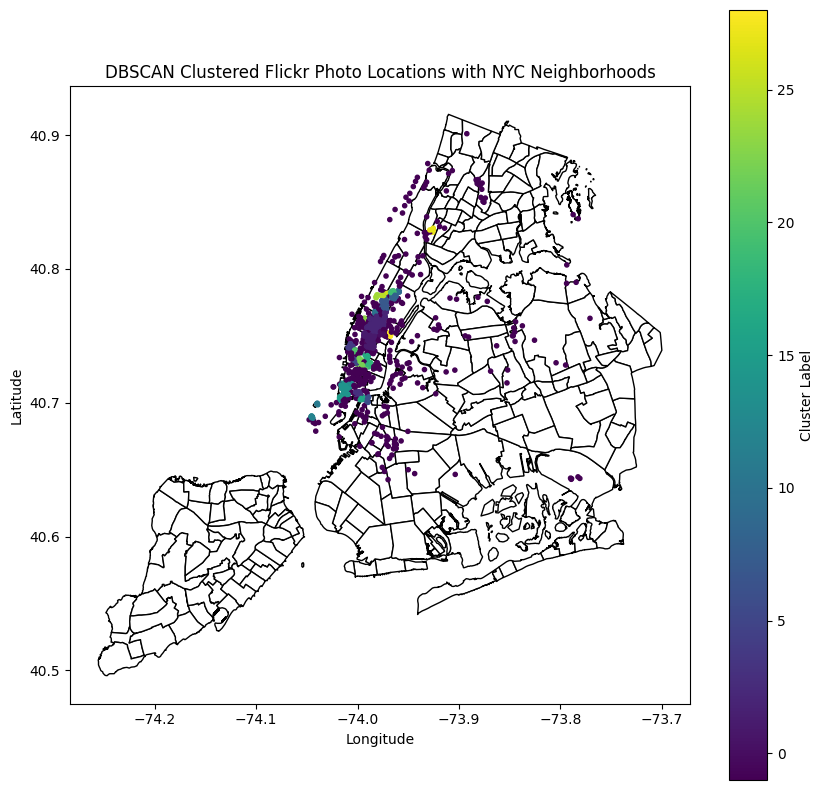

In [19]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
# Plot NYC neighborhoods
nyc_neighborhoods.plot(ax=ax, color='white', edgecolor='black')
# Plot clustered points
scatter = ax.scatter(coordinates[:, 1], coordinates[:, 0], c=cluster_labels, cmap='viridis', marker='.')

# Customizations
plt.title('DBSCAN Clustered Flickr Photo Locations with NYC Neighborhoods')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

##### Step 7: Can further zoom to Manhatton by setting the axis to [-74.05,-73.92,40.67,40.83] after the map is plotted

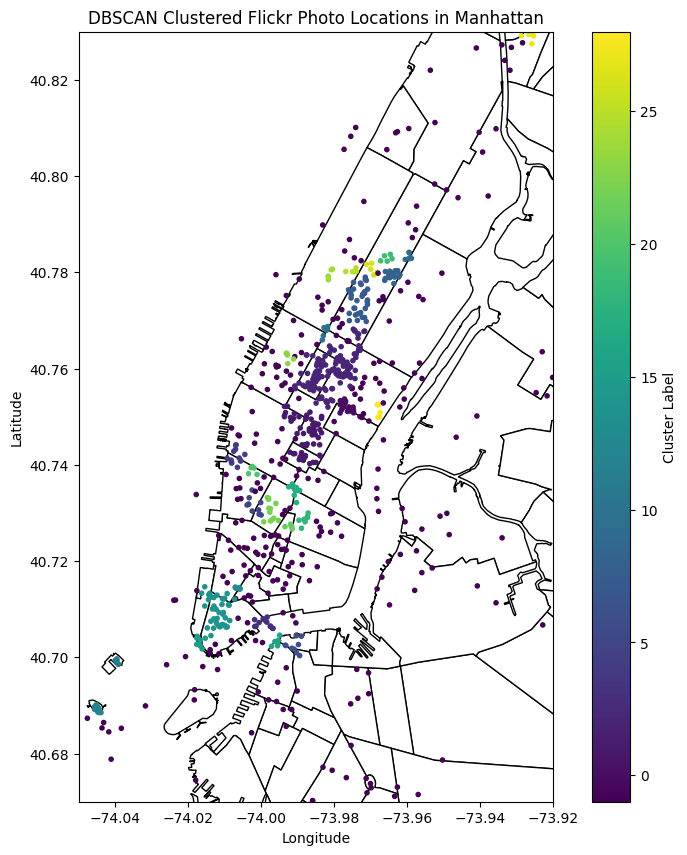

In [20]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
# Plot NYC neighborhoods
nyc_neighborhoods.plot(ax=ax, color='white', edgecolor='black')
# Plot clustered points
scatter = ax.scatter(coordinates[:, 1], coordinates[:, 0], c=cluster_labels, cmap='viridis', marker='.')
# Zoom into Manhattan
plt.axis([-74.05, -73.92, 40.67, 40.83])

# Customizations
plt.title('DBSCAN Clustered Flickr Photo Locations in Manhattan')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Cluster Label')
plt.show()